<a href="https://colab.research.google.com/github/higordevellard/Machine_Learning_Electrical_Fault/blob/main/machine_learning_curto_circuito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Predição de Curto-Circuito
# Sprint 02 - MVP parte 01






In [1]:
import requests
from PIL import Image
from io import BytesIO

# Carregar a capa do projeto usando a biblioteca PIL
imagem_1 = 'https://raw.githubusercontent.com/higordevellard/Machine_Learning_Electrical_Fault/main/imagens/imagem_1.png'
request_imagem = requests.get(imagem_1)
imagem = Image.open(BytesIO(request_imagem.content))
imagem.show()


# 1.Motivação

*   Os curtos-circuitos são falhas que acontecem em diversos equipamentos elétricos como os transformadores, motores e geradores, resumindo os curtos-circuitos podem estar presentes em todos setores do sistema de energia, desde a geração, linhas de trasmissão e distribuição, até o consumidor final.
*   Dessa maneira, se faz necessário que quando a falha ocorra, equipamentos de proteção como os disjuntores e relés atuem instantâneamente para evitar danos permanentes aos equipamentos elétricos.
*   Este projeto visa estudar um modelo de machine learning supervisionado que tem o objetivo de treinar um dataset contendo atributos quantitativos de tensão e corrente de uma linha de transmissão e utilizando os principais algoritmos de machine learning de classificação para identifcar quando ocorre o curto-circuito e diferencia-lo entre os tipo de curtos-circuitos existentes.


# 2.Pacotes Usados

In [2]:
# Configuração para não exibir os warnings dos pacotes selecionados
import warnings
warnings.filterwarnings("ignore")

# Importação de pacotes
import requests
from PIL import Image
from io import BytesIO
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

# 3.Carga do Dataset

O dataset escolhido para este projeto está disponível no Kaggle, conforme o seguinte endereço: https://www.kaggle.com/code/sahillyraina/electric-faults-detection-classification/input


In [3]:
# Localicazão do dataset
url_1 = 'https://raw.githubusercontent.com/higordevellard/Machine_Learning_Electrical_Fault/main/classData.csv'

# Labels dos atributos do dataset
labels_atributos = ['Groung_fault', 'Cond_C_fault', 'Cond_B_fault', 'Cond_A_fault', 'Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

# Lê o arquivo
dataset = pd.read_csv(url_1, names=labels_atributos, header=0, delimiter=',')


## **3.1Informações sobre o dataset**

*   O dataset carregado contém registros de tensão (Em volts) e corrente (Em amperes) dos condutores pertencentes ao sistema de transmissão de energia elétrica dos EUA.

*   Os Atributos presentes no dataset, estão dividos em inputs e outputs, sendo:

**Inputs:**

'Ia', 'Ib' e 'Ic' = Valores de Corrente registrados em Amperes (A) nos condutores A, B e C.

'Va', 'Vb' e 'Vc' = Valores de Tensão registrados em Volts (V) nos condutores A, B e C.

**Outputs:**

'Cond_A_fault', 'Cond_B_fault', 'Cond_B_fault' e 'Ground_fault', atributos binários onde: '0' corresponde a ausência de curto circuito, e '1' presença de curto circuito, podendo estar presente no condutor A,B,C ou Ground (Terra) que é o condutor de proteção.




#### **3.1.1.Descrição dos tipos de Curto-Circuito**

Existem diversos tipos de curto-circuito, que podem acontecer devido à fatores externos e internos como o contato com objetos (galhos, passaros, balões, etc), Falha do isolamento dos condutores, descargas atmosféricas, erro humano e vibração dos cabos. Dessa maneira os curtos são classificados como simétricos e assimétricos, sendo:  

1.  Curto Circuito - Simétrico

  São faltas balanceadas e podem acontecer entre as três fases (A,B e C) ou (A,B,C e Ground). São mais difíceis de ocorrer, porém são as que apresentam poder destrutivo maior. Normalmente cerca de 5% dos curtos-circuitos são simétricos.

2.  Curto Circuito - Assimétrico

  São faltas desbalanceadas que podem ocorrer entre as fases, ou entre as fase e a Terra (Ground). Ex: Condutor A e Condutor B, Condutor B e Ground, condutor C e Ground e etc. Ocorrem com mais frequência no sistema elétrico.



# 4.Análise Exploratória de Dados

##4.1.Análise e Tratamento dos dados

In [4]:
# Mostra as dimensões do dataset (linhas e colunas)
dataset.shape

(7861, 10)

In [5]:
# Mostra as informações do dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Groung_fault  7861 non-null   int64  
 1   Cond_C_fault  7861 non-null   int64  
 2   Cond_B_fault  7861 non-null   int64  
 3   Cond_A_fault  7861 non-null   int64  
 4   Ia            7861 non-null   float64
 5   Ib            7861 non-null   float64
 6   Ic            7861 non-null   float64
 7   Va            7861 non-null   float64
 8   Vb            7861 non-null   float64
 9   Vc            7861 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 614.3 KB


**Observações importantes levantadas após os resultados da função .info():**

1)Todos os 10 atributos foram devidamente carregados.

2)Todas as 7861 Instâncias (linhas) são não nulas (Sem missings).



In [6]:
# Verificar a presença de linhas duplicadas no dataset.
print(dataset.duplicated().sum())

0


In [7]:
# Mostra as 5 primeiras linhas do dataset
dataset.head(5)

Groung_fault  Cond_C_fault  Cond_B_fault  Cond_A_fault          Ia  \
0             1             0             0             1 -151.291812   
1             1             0             0             1 -336.186183   
2             1             0             0             1 -502.891583   
3             1             0             0             1 -593.941905   
4             1             0             0             1 -643.663617   

           Ib          Ic        Va        Vb        Vc  
0   -9.677452   85.800162  0.400750 -0.132935 -0.267815  
1  -76.283262   18.328897  0.312732 -0.123633 -0.189099  
2 -174.648023  -80.924663  0.265728 -0.114301 -0.151428  
3 -217.703359 -124.891924  0.235511 -0.104940 -0.130570  
4 -224.159427 -132.282815  0.209537 -0.095554 -0.113983

Considerando que no output do dataset (Quatro primeiras colunas) já está sendo usada a codificação em "one-hot encoding", porém, será mais conveniente concatenar as quatro primeiras colunas para que que sejá possível classificar em uma única coluna o tipo de curto-circuito, Dessa maneira, será criado o atributo 'Tipo_de_Curto_Circuito'.

In [8]:
# Criando a nova coluna
dataset['Tipo_de_Curto_Circuito'] = dataset.iloc[:, 0:4].apply(lambda row: ''.join(str(x) for x in row), axis=1)

# Exibindo o dataset com a nova coluna
dataset.head(5)

Groung_fault  Cond_C_fault  Cond_B_fault  Cond_A_fault          Ia  \
0             1             0             0             1 -151.291812   
1             1             0             0             1 -336.186183   
2             1             0             0             1 -502.891583   
3             1             0             0             1 -593.941905   
4             1             0             0             1 -643.663617   

           Ib          Ic        Va        Vb        Vc Tipo_de_Curto_Circuito  
0   -9.677452   85.800162  0.400750 -0.132935 -0.267815                   1001  
1  -76.283262   18.328897  0.312732 -0.123633 -0.189099                   1001  
2 -174.648023  -80.924663  0.265728 -0.114301 -0.151428                   1001  
3 -217.703359 -124.891924  0.235511 -0.104940 -0.130570                   1001  
4 -224.159427 -132.282815  0.209537 -0.095554 -0.113983                   1001

In [9]:
# Identificar os valores únicos da nova coluna.
valores_unicos = dataset['Tipo_de_Curto_Circuito'].unique()
for valor in valores_unicos:
    print(valor)

1001
1011
0110
0111
1111
0000


Dessa maneira, foi criada uma classificação para os possíveis tipos de curtos-circuitos existente no dataset, onde:


*   1001 - Curto-Circuito entre o ground (terra) e a fase A.
*   1011 - Curto-Circuito entre o ground (terra) e as fases A e B.
*   0110 - Curto-Circuito entre as fases C e B.
*   0111 - Curto-Circuito entre as fases A,B e C.
*   1111 - Curto-Circuito entre o ground (terra) e as fases A,B e C.
*   0000 - Ausência de Curto-Circuito.


**Visualização dos Curtos - Exemplificação**

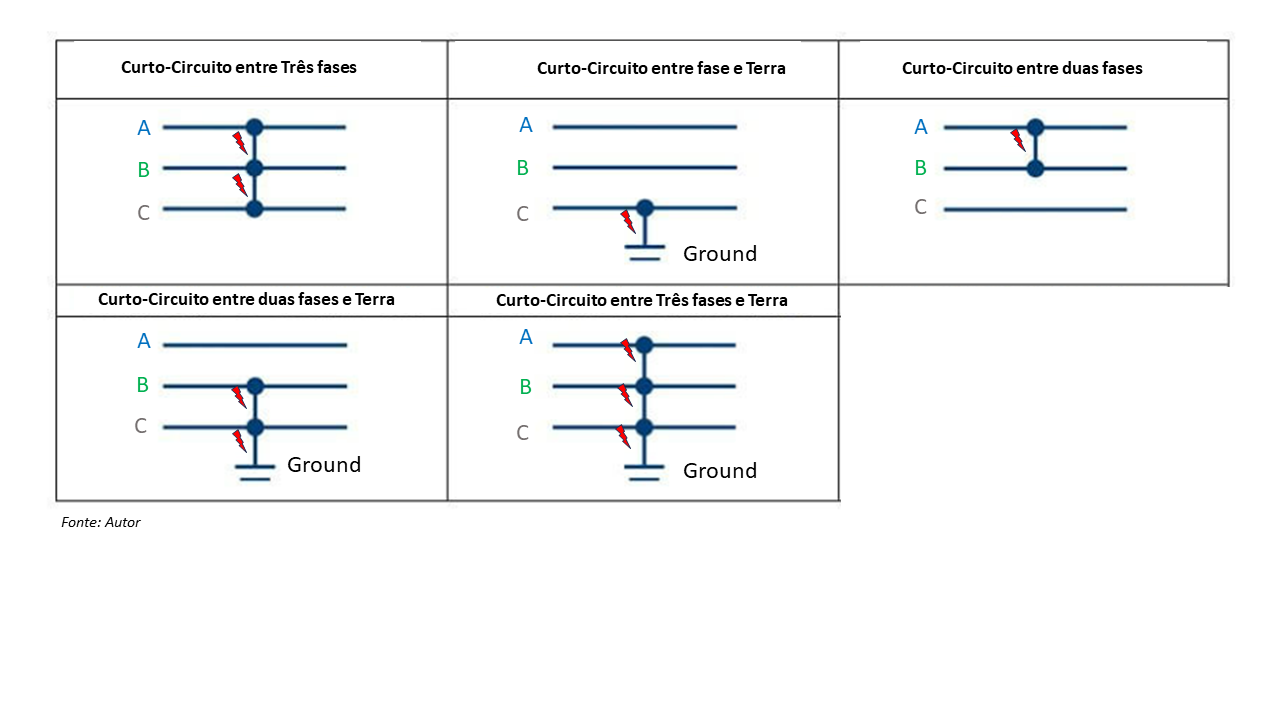

In [10]:
# Carregar a capa do projeto usando a biblioteca PIL
imagem_2 = 'https://raw.githubusercontent.com/higordevellard/Machine_Learning_Electrical_Fault/main/imagens/imagem_2.png'
request_imagem_2 = requests.get(imagem_2)
imagem_curto = Image.open(BytesIO(request_imagem_2.content))
imagem_curto.show()

## **4.2.Estatísticas Descritivas**

Considerando que deve-se fazer o resumo estatístico apenas dos atributos quantitativos, serão removidas as demais colunas.

In [11]:
# Resumo estatístico do dataset.
dataset.drop(['Groung_fault', 'Cond_C_fault', 'Cond_B_fault', 'Cond_A_fault', 'Tipo_de_Curto_Circuito'], axis=1).describe().round(2)

Ia       Ib       Ic       Va       Vb       Vc
count  7861.00  7861.00  7861.00  7861.00  7861.00  7861.00
mean     13.72   -44.85    34.39    -0.01     0.00     0.01
std     464.74   439.27   371.11     0.29     0.31     0.31
min    -883.54  -900.53  -883.36    -0.62    -0.61    -0.61
25%    -119.80  -271.85   -61.03    -0.13    -0.16    -0.22
50%       2.04     5.51    -4.33    -0.01     0.00     0.01
75%     227.25    91.19    49.12     0.11     0.15     0.24
max     885.74   889.87   901.27     0.60     0.63     0.60

Considerando os 7861 registros analisados, é apresentado os valores de (média, desvio padrão, mínimo, máximo e os quartis dos valores de corrente e tensão dos condutores).
É importante observar que o valor da média e desvio padrão das corretens "Ia", "Ib" e "Ic" são considerados muito altos justamente por que em caso de curto-circuito o valor da corrente assume valores extremos, diferente da tensão que não se altera tanto.

**Balanceamento dos Dados**

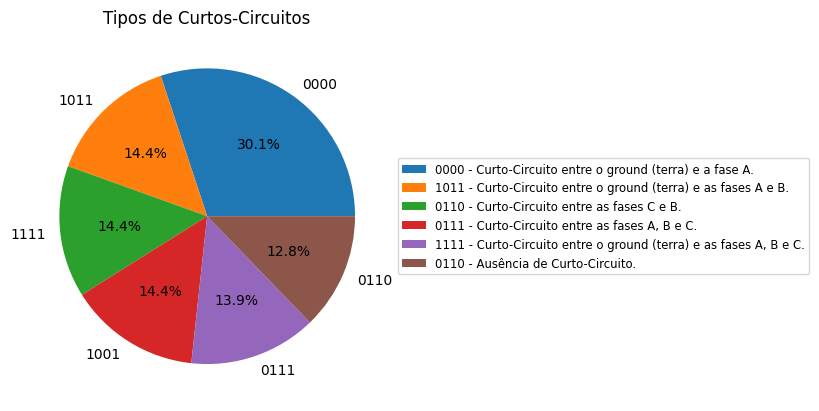

In [12]:
# Obtendo a contagem dos valores únicos do atributo "Tipo_de_Curto_Circuito"
contagem_valores = dataset['Tipo_de_Curto_Circuito'].value_counts()

# Obtendo os valores únicos e suas respectivas contagens
valores_unicos = contagem_valores.index
contagens = contagem_valores.values

# Definindo as descrições correspondentes a cada valor único
descricoes = ['0000 - Curto-Circuito entre o ground (terra) e a fase A.',
              '1011 - Curto-Circuito entre o ground (terra) e as fases A e B.',
              '0110 - Curto-Circuito entre as fases C e B.',
              '0111 - Curto-Circuito entre as fases A, B e C.',
              '1111 - Curto-Circuito entre o ground (terra) e as fases A, B e C.',
              '0110 - Ausência de Curto-Circuito.']

# Plotando o gráfico de pizza com porcentagem
plt.pie(contagens, labels=valores_unicos, autopct='%1.1f%%')

# Adicionando a legenda personalizada ao lado do gráfico
plt.legend(descricoes, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Definindo o título do gráfico
plt.title('Tipos de Curtos-Circuitos')

# Exibindo o gráfico
plt.show()

De acordo com o gráfico de piza pode-se ver que 30% dos registros são os que não há presença de curto, e as demais possibilidade de curto-circuito estão balanceadas entre 12% e 14% dos registros.

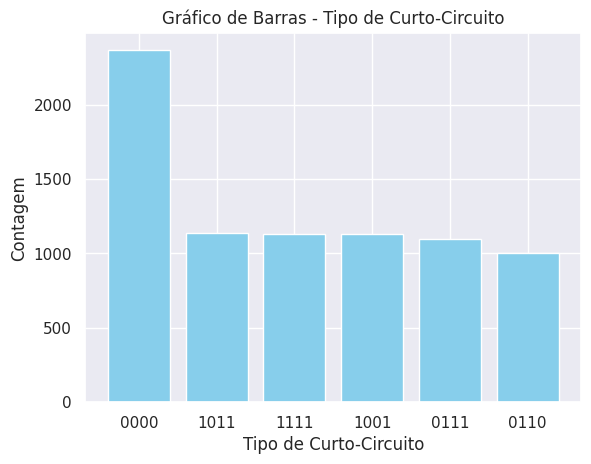

In [33]:
# Contar o número de ocorrências de cada categoria em "Tipo_de_Curto_Circuito"
contagem_por_tipo = dataset['Tipo_de_Curto_Circuito'].value_counts()

# Criar o gráfico de barras
plt.bar(contagem_por_tipo.index, contagem_por_tipo.values, color='skyblue')

# Adicionar rótulos e título
plt.xlabel('Tipo de Curto-Circuito')
plt.ylabel('Contagem')
plt.title('Gráfico de Barras - Tipo de Curto-Circuito')

# Mostrar o gráfico
plt.show()

**Histogramas**

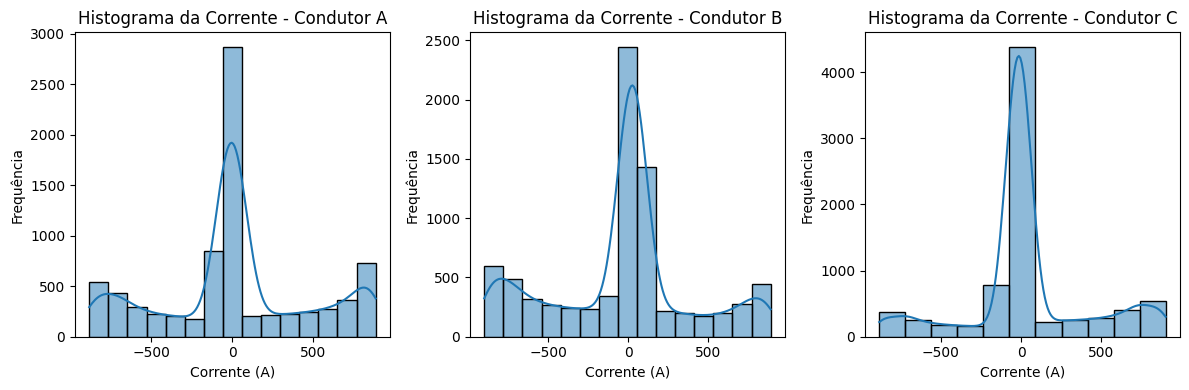

In [13]:
# Criar um subplot com uma linha e três colunas
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Plotar o histograma de pontuação de crédito
sns.histplot(dataset['Ia'], kde=True, bins=15, ax=axs[0])
axs[0].set_xlabel("Corrente (A)")
axs[0].set_ylabel("Frequência")
axs[0].set_title("Histograma da Corrente - Condutor A")

# Plotar o histograma de Idade
sns.histplot(dataset['Ib'], kde=True, bins=15, ax=axs[1])
axs[1].set_xlabel("Corrente (A)")
axs[1].set_ylabel("Frequência")
axs[1].set_title("Histograma da Corrente - Condutor B")

# Plotar o histograma de tempo de conta do correntista
sns.histplot(dataset['Ic'], kde=True, bins=11, ax=axs[2])
axs[2].set_xlabel("Corrente (A)")
axs[2].set_ylabel("Frequência")
axs[2].set_title("Histograma da Corrente - Condutor C")

# Ajuste de layout
plt.tight_layout()

# Exibição dos histogramas
plt.show()

O Histograma acima irá expressar a frequência de cada valor de corrente para cada condutor. A frequência maior fica em torno de 0 (A), e os valores extremos sinalizam a presença de curto-circuito. Como os valores são senoidais, justifica a maior frequência em trono do zero.

In [14]:
# Criar um subplot com uma linha e três colunas
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Plotar o histograma de pontuação de crédito
sns.histplot(dataset['Va'], kde=True, bins=15, ax=axs[0])
axs[0].set_xlabel("Tensão (V)")
axs[0].set_ylabel("Frequência")
axs[0].set_title("Histograma da Tensão - Condutor A")

# Plotar o histograma de Idade
sns.histplot(dataset['Vb'], kde=True, bins=15, ax=axs[1])
axs[1].set_xlabel("Tensão (V)")
axs[1].set_ylabel("Frequência")
axs[1].set_title("Histograma da Tensão - Condutor B")

# Plotar o histograma de tempo de conta do correntista
sns.histplot(dataset['Vc'], kde=True, bins=11, ax=axs[2])
axs[2].set_xlabel("Tensão (V)")
axs[2].set_ylabel("Frequência")
axs[2].set_title("Histograma de Tensão - Condutor C")

# Ajuste de layout
plt.tight_layout()

# Exibição dos histogramas
plt.show()

O Histograma acima mostra a frequência dos valores de tensão. Pode-se observar que a tensão registrada em Volts praticamente não se altera na presença de um curto-circuito, como foi visto no caso da corrente. Isso é fácilmente explicado pela primeira lei de Ohm **(V=R.I)**, que é uma das leis fundamentais da eletricidade e que nos explica que a corrente é diretamente proporcional a tensão aplicada e inversamente proporcional à resistência do circuito. Como a resistência em um curto é extremamente baixa, justifica a corrente assumir valores extremos.

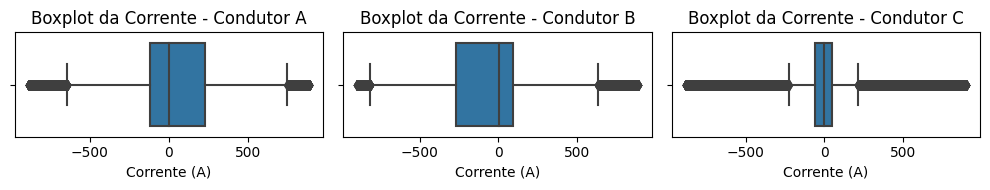

In [15]:
# Criar um subplot com uma linha e três colunas
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))

# Plotar o boxplot de pontuação de crédito
sns.boxplot(x="Ia", data=dataset, ax=axs[0])
axs[0].set_title("Boxplot da Corrente - Condutor A")
axs[0].set_xlabel("Corrente (A)")

# Plotar o boxplot de Idade
sns.boxplot(x="Ib", data=dataset, ax=axs[1])
axs[1].set_title("Boxplot da Corrente - Condutor B")
axs[1].set_xlabel("Corrente (A)")

# Plotar o boxplot do tempo de correntista
sns.boxplot(x="Ic", data=dataset, ax=axs[2])
axs[2].set_title("Boxplot da Corrente - Condutor C")
axs[2].set_xlabel("Corrente (A)")

# Ajuste de layout
plt.tight_layout()

# Exibição dos boxplots
plt.show()


Analisando o Boxplot da corrente nos condutores é natural o boxplot considerar uma quantidade grande de registros como sendo possíveis "outliers", porém, como se trata de valores de curto-circuito, onde a corrente registra valores extremamente altos, os mesmos não poderão ser descartados como outliers.

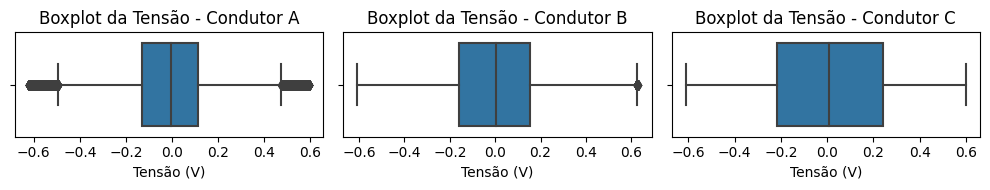

In [16]:
# Criar um subplot com uma linha e três colunas
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))

# Plotar o boxplot de pontuação de crédito
sns.boxplot(x="Va", data=dataset, ax=axs[0])
axs[0].set_title("Boxplot da Tensão - Condutor A")
axs[0].set_xlabel("Tensão (V)")

# Plotar o boxplot de Idade
sns.boxplot(x="Vb", data=dataset, ax=axs[1])
axs[1].set_title("Boxplot da Tensão - Condutor B")
axs[1].set_xlabel("Tensão (V)")

# Plotar o boxplot do tempo de correntista
sns.boxplot(x="Vc", data=dataset, ax=axs[2])
axs[2].set_title("Boxplot da Tensão - Condutor C")
axs[2].set_xlabel("Tensão (V)")

# Ajuste de layout
plt.tight_layout()

# Exibição dos boxplots
plt.show()

O Boxplot para os valores de tensão identifica possíveis outliers em torno de -0,6 e 0,6 Volts, porém são valores que podem ser considerados, uma vez que também são vistos em outros condutores.





**Correlação Heatmap**

<Axes: >

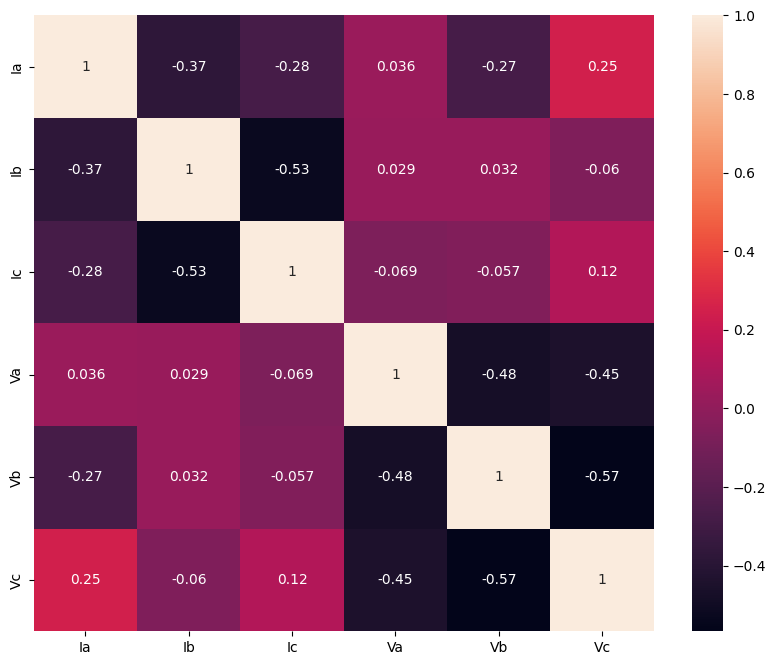

In [17]:
#Achar a correlação entre os atributos
dataset_2 = dataset.drop(['Groung_fault', 'Cond_C_fault', 'Cond_B_fault', 'Cond_A_fault', 'Tipo_de_Curto_Circuito'], axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(dataset_2.corr(), fmt='.2g', annot=True)

O gráfico acima busca encontrar alguma correlação entre os valores de corrente e tensão para cada condutor. A relação existente entre as fases A,B e C é que em regime normal de funcionamento (Sem curto-circuito) os valores máximos e mínimos de tensão e corrente devem ser os mesmos para cada condutor, porém sendo registrados em frequências diferente, estando defasados em 120° cada fase.

**Gráfico Scatterplot**

Com o objetivo de facilitar a visualização dos dados, foi criado uma nova coluna apenas para identificar se houve curto ou não.

In [18]:
# Criando o novo dataset com a coluna "Houve_Curto-Circuito?"
dataset_3 = dataset.assign(Houve_Curto_Circuito=lambda x: ['Sim' if valor in ['1001', '1011', '0110', '0111', '1111'] else 'Não' for valor in x['Tipo_de_Curto_Circuito']])

# Exibindo o novo dataset com a nova coluna
dataset_3.head()

Groung_fault  Cond_C_fault  Cond_B_fault  Cond_A_fault          Ia  \
0             1             0             0             1 -151.291812   
1             1             0             0             1 -336.186183   
2             1             0             0             1 -502.891583   
3             1             0             0             1 -593.941905   
4             1             0             0             1 -643.663617   

           Ib          Ic        Va        Vb        Vc  \
0   -9.677452   85.800162  0.400750 -0.132935 -0.267815   
1  -76.283262   18.328897  0.312732 -0.123633 -0.189099   
2 -174.648023  -80.924663  0.265728 -0.114301 -0.151428   
3 -217.703359 -124.891924  0.235511 -0.104940 -0.130570   
4 -224.159427 -132.282815  0.209537 -0.095554 -0.113983   

  Tipo_de_Curto_Circuito Houve_Curto_Circuito  
0                   1001                  Sim  
1                   1001                  Sim  
2                   1001                  Sim  
3                   1001                  Sim  
4                   1001                  Sim

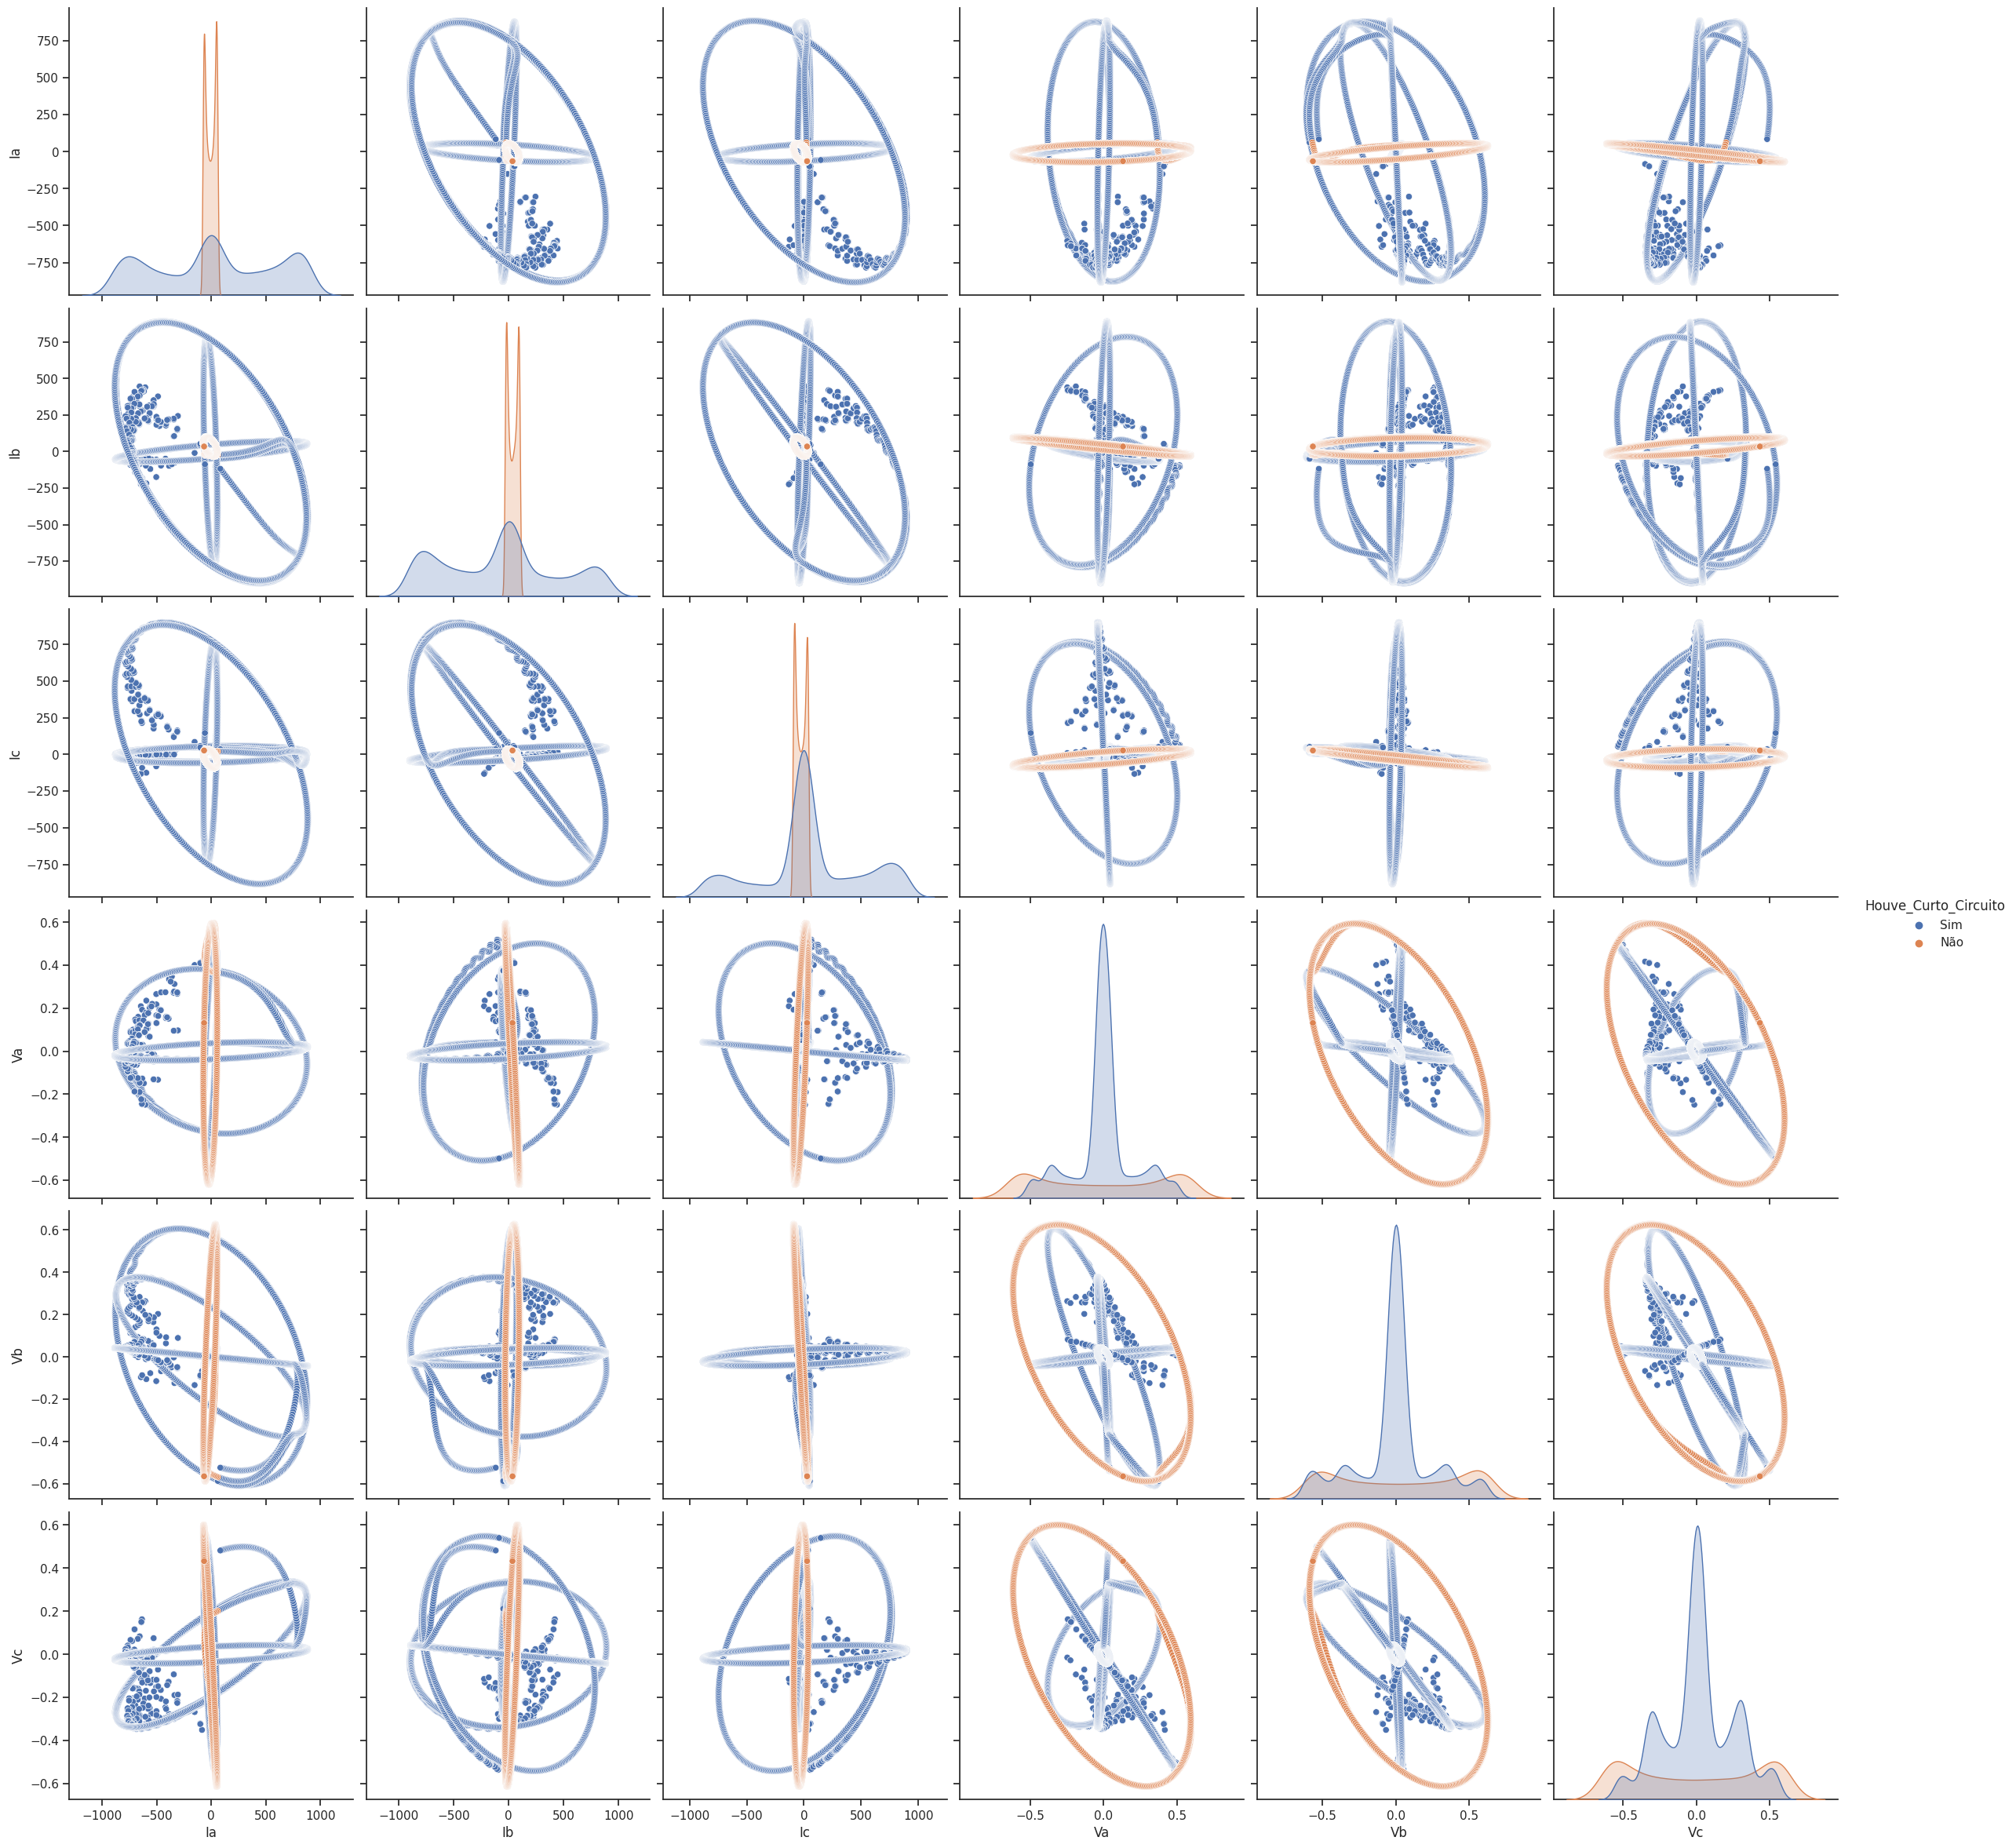

In [19]:
dataset_4 = dataset_3.drop(['Groung_fault', 'Cond_C_fault', 'Cond_B_fault', 'Cond_A_fault'], axis=1)

sns.set_theme(style="ticks")

df = dataset_4
sns.pairplot(df, hue="Houve_Curto_Circuito", height=4)  # Definindo altura como 4 polegadas

plt.show()

Com o Scatterplot, foi possível gerar visualizações entre corrente e tensão dos condutores. Para melhor visualização, foi dividido apenas entre registros com curto-circuito ou sem. O formato "redondo" dos registros se explica pelo comportamento senoidal da corrente e tensão.

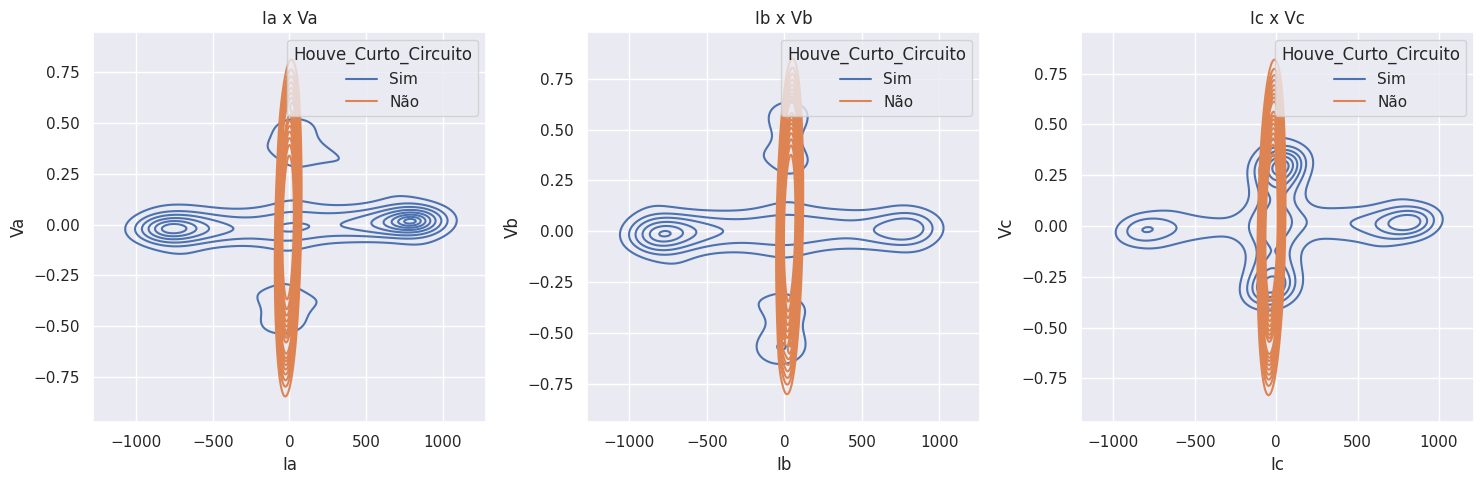

In [20]:
sns.set_theme(style="darkgrid")

# Criando os subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Definindo as combinações de x e y
x_values = ['Ia', 'Ib', 'Ic']
y_values = ['Va', 'Vb', 'Vc']

# Loop para criar os gráficos individuais
for i, (x, y) in enumerate(zip(x_values, y_values)):
    # Selecionando os dados correspondentes a cada combinação de x e y
    data = dataset_4[[x, y, 'Houve_Curto_Circuito']]

    # Definindo o subplot adequado
    ax = axs[i]

    # Plotando o gráfico de contorno
    sns.kdeplot(data=data, x=x, y=y, hue='Houve_Curto_Circuito', thresh=.1, ax=ax)

    # Definindo os títulos dos subplots
    ax.set_title(f'{x} x {y}')
    ax.set_xlabel(x)
    ax.set_ylabel(y)

# Ajustando o espaçamento entre os subplots
plt.tight_layout()

# Exibindo os gráficos
plt.show()

No gráfico acima pode-se visualizar em quais pontos do gráfico Tensão x Corrente há a presença de curto-circuito ou não. Ao criar um modelo de Machine-Learning para detectar um curto-circuito, o modelo deverá reconhecer facilmente que com correntes altas há a presença do curto, porém, como a corrente e a tensão são senoidais, periódicamente os valores irão se assemelhar à valores de operação normal, dificultando o aprendizado do modelo. O mesmo vale para a tensão.

# **5.Modelagem e Inferência**

## 5.1.Separação em conjunto de treino e conjunto de teste com holdout

In [21]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,4:10]
y = array[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Importância de Atributos com ExtraTrees

# Criação do modelo para seleção de atributos
modelo = ExtraTreesClassifier(n_estimators=100)
modelo.fit(X,y)

# Exibe os atributos orginais
print("\nAtributos Originais:", dataset.columns[0:14])

# Exibe a pontuação de importância para cada atributo (quanto maior a pontuação, mais importante é o atributo).
print(modelo.feature_importances_)

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação


Atributos Originais: Index(['Groung_fault', 'Cond_C_fault', 'Cond_B_fault', 'Cond_A_fault', 'Ia',
       'Ib', 'Ic', 'Va', 'Vb', 'Vc', 'Tipo_de_Curto_Circuito'],
      dtype='object')
[0.18398864 0.18895742 0.20827034 0.13881258 0.13446925 0.14550177]


Foi dada uma pontuação para os atributos com a finalidade de definir a importância de cada um. Como esperado, os atributos que se referem à corrente nos condutores possuem uma nota maior pois são os mais afetados durante um curto-circuito, ao contrato dos demais atributos referentes á tensão nos condutores. Porém como temos apenas 6 atributos, iremos manter todos para a criação do algorítmo.

In [22]:
print("Dados de treino:")
print(X_train)  # Exibir primeiras linhas dos atributos de treino
print(y_train)  # Exibir primeiras linhas dos rótulos de treino

Dados de treino:
[[-58.76606348 -50.80814515 111.9082284 -0.492879312 -0.041879177
  0.534758489]
 [441.7059785 -14.77604334 44.01006859 0.297165503 -0.596759949
  0.299594446]
 [39.21879516 745.7430072 -782.9198497 0.038320297 -0.00355336
  -0.034766938]
 ...
 [-532.7703066 0.762722099 -39.59120622 -0.245047501 0.566525887
  -0.321478386]
 [-391.5465155 -65.97548358 43.8719659 0.364772168 -0.415344651
  0.050572483]
 [-71.60286103 61.73860535 6.759810797 -0.11492185 -0.447094794
  0.562016645]]
['0110' '1001' '0111' ... '1001' '1001' '0000']


## **5.2.Criação e avaliação de modelos: dados padronizados e normalizados**

Considerando que alguns modelos podem apresentar melhores resultados quando os dados estão padronizados ou normalizados, então será realizada a comparação para avaliar se algum algoritmo irá superar a acurácia alcançada até o momento.

LR-orig: 0.348 (0.007)
KNN-orig: 0.816 (0.011)
CART-orig: 0.878 (0.014)
NB-orig: 0.797 (0.011)
SVM-orig: 0.751 (0.012)
Bag-orig: 0.875 (0.011)
RF-orig: 0.873 (0.013)
ET-orig: 0.873 (0.012)
Ada-orig: 0.632 (0.048)
GB-orig: 0.848 (0.011)
Vot-orig: 0.720 (0.013)
LR-padr: 0.346 (0.006)
KNN-padr: 0.816 (0.010)
CART-padr: 0.877 (0.013)
NB-padr: 0.795 (0.010)
SVM-padr: 0.810 (0.009)
Bag-padr: 0.875 (0.012)
RF-padr: 0.873 (0.012)
ET-padr: 0.876 (0.012)
Ada-padr: 0.632 (0.048)
GB-padr: 0.849 (0.011)
Vot-padr: 0.767 (0.013)
LR-norm: 0.338 (0.008)
KNN-norm: 0.829 (0.012)
CART-norm: 0.876 (0.013)
NB-norm: 0.795 (0.010)
SVM-norm: 0.812 (0.008)
Bag-norm: 0.873 (0.013)
RF-norm: 0.873 (0.010)
ET-norm: 0.875 (0.013)
Ada-norm: 0.632 (0.048)
GB-norm: 0.850 (0.011)
Vot-norm: 0.767 (0.010)


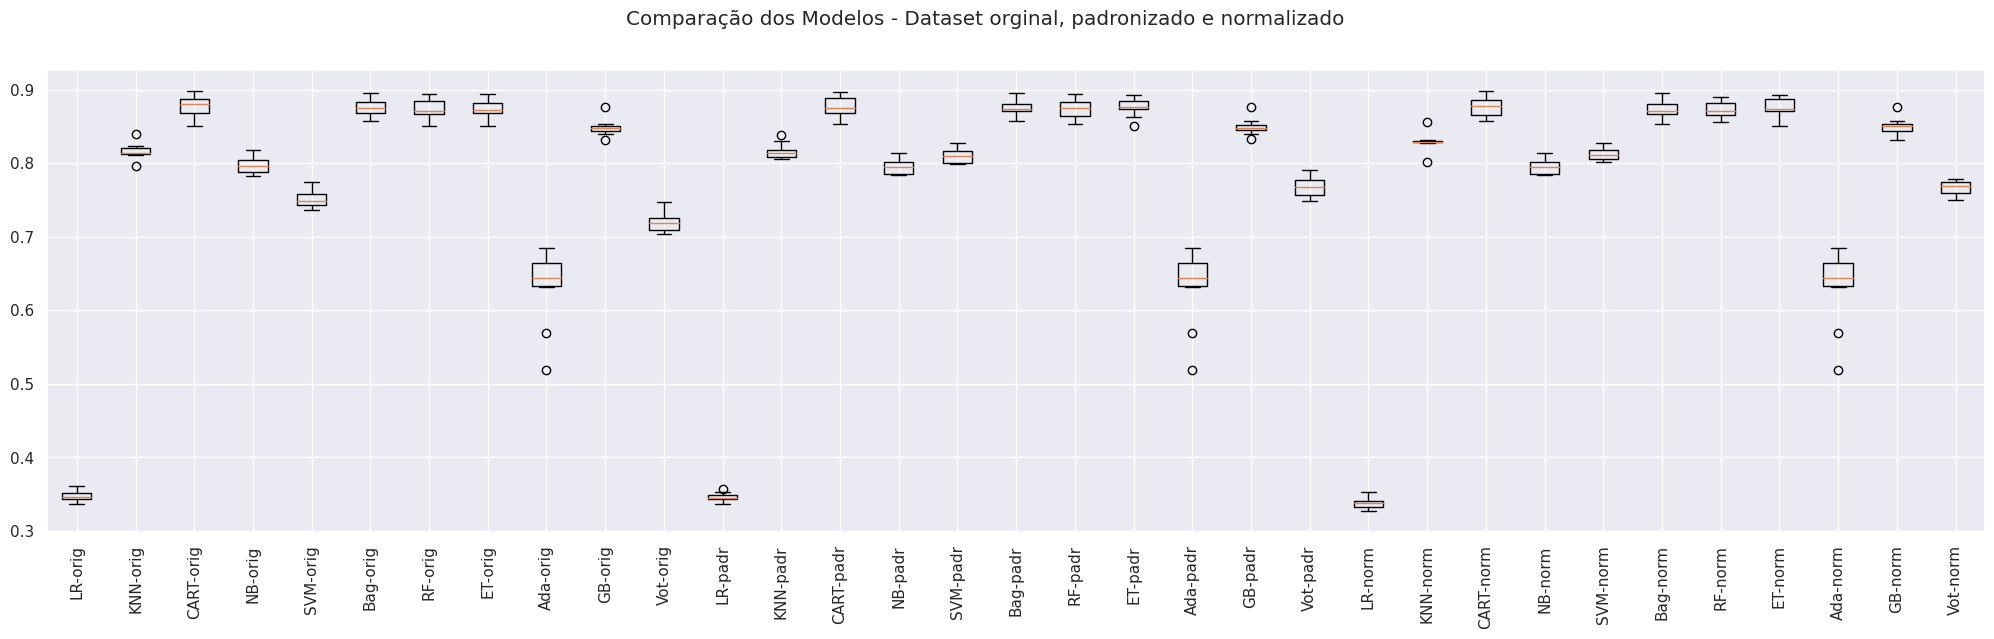

In [23]:
np.random.seed(7) # definindo uma semente global para este bloco

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

Ao comparar os modelos utilizando o dataset original, padronizado e normalizado, foi possível observar que alguns modelos apresentaram melhores ao normalizar ou padronizar os dados e outros diminuiram a acurácia, porém os que continuam mostrando melhores resultados são: "CART, "BAG", "RF" e "ET".

**Optimização dos Hiperparâmetros**



A partir dessa etapa, foi escolhido o modelo CART (Árvore de Decisão) para prosseguirmos com a optimização dos hiperparâmetros.

In [24]:
# Tuning do CART

np.random.seed(7)  # Definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
cart = ('CART', DecisionTreeClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('cart-orig', Pipeline(steps=[cart])))
pipelines.append(('cart-padr', Pipeline(steps=[standard_scaler, cart])))
pipelines.append(('cart-norm', Pipeline(steps=[min_max_scaler, cart])))

param_grid = {
    'CART__criterion': ['gini', 'entropy'],
    'CART__max_depth': [None, 5, 10, 20],
    'CART__min_samples_split': [2, 5, 10],
    'CART__min_samples_leaf': [1, 2, 4]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))


Sem tratamento de missings: cart-orig - Melhor: 0.879610 usando {'CART__criterion': 'entropy', 'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Sem tratamento de missings: cart-padr - Melhor: 0.881041 usando {'CART__criterion': 'entropy', 'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Sem tratamento de missings: cart-norm - Melhor: 0.880407 usando {'CART__criterion': 'entropy', 'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}


**Finalização do Modelo**

In [25]:
# Preparing the model
scaler = StandardScaler().fit(X_train)  # ajustar o scaler com o conjunto de treinamento
rescaledX = scaler.transform(X_train)  # aplicar o padrão ao conjunto de treinamento
model = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1)
model.fit(rescaledX, y_train)


DecisionTreeClassifier(criterion='entropy')

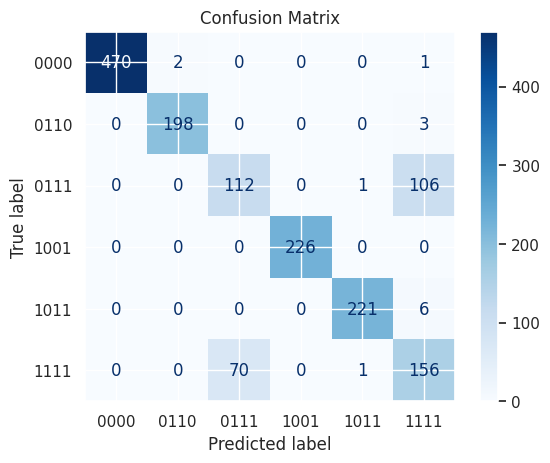

In [35]:
# Use OneVsRestClassifier to transform the multiclass problem into multiple binary problems
ovr_model = OneVsRestClassifier(model)

# Fit the OneVsRestClassifier on the training data
ovr_model.fit(rescaledX, y_train)

# Make predictions on the test set
X_test_rescaled = scaler.transform(X_test)
y_pred = ovr_model.predict(X_test_rescaled)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues, values_format='.0f')
plt.title('Confusion Matrix')
plt.show()

A matriz de confusão nos mostra a frequência de classificação de cada classe, pode-se perceber que em geral o modelo previu muito bem para diversas classes, porém apresentou dificuldades para diferenciar os curtos entre as fases A,B e C (1111)  e o curto entre a terra (ground) e as fases A,B e C (0111), pois de fato são bem semelhantes.

In [37]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

        0000       1.00      0.99      1.00       473
        0110       0.99      0.99      0.99       201
        0111       0.62      0.51      0.56       219
        1001       1.00      1.00      1.00       226
        1011       0.99      0.97      0.98       227
        1111       0.57      0.69      0.63       227

    accuracy                           0.88      1573
   macro avg       0.86      0.86      0.86      1573
weighted avg       0.88      0.88      0.88      1573



O resultado do Classification Report fornece uma avaliação detalhada do desempenho do modelo de classificação em cada classe e também uma média ponderada (weighted avg) das métricas de precisão (precision), recall (taxa de verdadeiros positivos) e F1-score para todas as classes. Vamos explicar as principais métricas e os resultados:

precision (precisão): É a proporção de verdadeiros positivos (TP) em relação a todas as instâncias classificadas como positivas (verdadeiros positivos mais falsos positivos). Em outras palavras, mede a precisão do modelo em prever corretamente as amostras positivas. Onde valores próximos de 1 são melhores.

recall (taxa de verdadeiros positivos): É a proporção de verdadeiros positivos (TP) em relação a todas as instâncias reais que são realmente positivas (verdadeiros positivos mais falsos negativos). Em outras palavras, mede a capacidade do modelo de identificar corretamente todas as amostras positivas. Valores mais próximos de 1 são melhores.

f1-score: É a média harmônica entre a precisão e o recall. É uma medida balanceada que leva em consideração tanto a precisão quanto a capacidade de identificar corretamente as amostras positivas. Valores mais próximos de 1 são melhores.

support: É o número de instâncias reais de cada classe no conjunto de teste.

accuracy (acurácia): É a proporção de todas as previsões corretas em relação ao número total de instâncias no conjunto de teste.

Com isso, foi possível observar o seguinte resultado:

*   Em geral a maioria das classes possuem uma alta precisão, ou seja, que quase todas as previsões foram corretas. Apresentando também um recall alto, assim como o F1-Score.
*   Como identificado também na matriz confusão, as classes (0111) e (1111) são as que possuem menor precisão, recall e F1-Score, identificando um desempenho moderado desta classe.

A macro avg é a média não ponderada das métricas para todas as classes, enquanto a weighted avg é a média ponderada, levando em consideração o suporte (número de instâncias) de cada classe. A macro avg e weighted avg fornecem uma visão geral do desempenho médio do modelo em todas as classes.

No geral, um f1-score alto é desejável para todas as classes, indicando um bom equilíbrio entre precisão e recall. A acurácia global do modelo é de 0.88, o que é uma medida geral do desempenho global do modelo, mas lembre-se de que, dependendo do problema e do desequilíbrio de classes, outras métricas, como o f1-score, podem ser mais informativas.

In [27]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

DecisionTreeClassifier(criterion='entropy')

# **6.Simulando a aplicação do modelo em dados não vistos**

In [28]:
# Novos dados - não sabemos a classe!
data = {'Ia':  [3, -150, 1],
        'Ib': [1, -10, 500],
        'Ic': [1, 85, 500],
        'Va': [0.4, 0.4, 0.2],
        'Vb': [0.1, -0.13, 0.5],
        'Vc': [0.2, -0.30, 0.2],
        }

atributos = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,:6].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[-0.02307062  0.10437378 -0.08998613  1.40996975  0.31538768  0.62844795]
 [-0.35230671  0.07933059  0.13637783  1.40996975 -0.41845865 -0.99557435]
 [-0.02737436  1.24042371  1.25472359  0.71824369  1.59164219  0.62844795]]


In [29]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

['0000' '1001' '0110']


Fazendo uma simulação, o modelo conseguiu acertar as três situações que foram inseridas. A primeira com dados de operação normal sem curto '0000'. Na segunda, um curto na fase A e Terra '1001' e  por ultimo curto entre as fases B e C '0110'

# **7.Conclusão**

O algorítimo de Machine Learning criado para resolver o problema de classificação de curtos-circuitos em uma linha de transmissão de energia apresentou resultados satisfatórios.


Inicialmente, foi feito toda a análise exploratória dos dados para que fosse possível tirar alguns insights interessante sobre os dados, como observar qual é o comportamento da corrente e tensão na presença de curtos-circuitos. Após essa etapa, se deu início ao pré-processamento, normalizando e padronizando os dados de treino.


Em seguida, utilizando diferentes algorítmos de classificação como KNN, CART, SVM, Random Forest, entre outros, foi possível achar o algoritmo que apresentou a melhor acurácia, sendo o 'CART' (Árvore de decisão), aprentando acurácia de 0,878 com os dados originais.


Escolhendo o CART como o melhor algorítmo para seguir com o modelo, seguiu-se então para a optmização dos Hiperparâmetros, que dessa vez atingiu a acurácia de 0,881 com os dados padronizados. Por fim, o modelo foi finalizado utilizando o algorítimo da Árvore de decisão, com os dados padronizados e quatro hiperparâmetros selecionados pelo GridSearch.

O algorítmo usado apresenta funções semelhantes à um relé de proteção usado em um sistema elétrico, que ao detectar um curto-circuito realiza a tomada de decisão de ativar um disjuntor ou uma chave seccionadora, tal decisão tem que ser feita quase que instântania, levando milisegundos e com uma acurácia próxima de 100% para que interrompa com precisão os condutores certos e não danifique o equipamento elétrico expondo-o à correntes elétricas extremas. Atualmente o relé continua sendo uma opção mais confiável do que este modelo de Machine Learning apresentado, porém, melhorias podem ser feitas para melhorar o treinamento do modelo e atingir melhores resultados.
